# Exploratory Data Analysis

## Imports

In [ ]:
from itertools import islice

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

import os
from math import ceil

import cv2
import matplotlib
from sklearn.decomposition import PCA

## Constants

In [ ]:
DATA_DIR = 'data/'
os.makedirs(DATA_DIR, exist_ok=True)

CSV_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_bb_onehot.csv')
IMAGES_ARCHIVE_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_256x256.tar.gz')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')

## Download the prepared data

In [ ]:
if not os.path.exists(CSV_FILE):
    ! gdown --id 1i7oUN9QTjOavTPGgvWKq22InrTFN6mYH -O $CSV_FILE
else:
    print('CSV file ({}) already exists.'.format(CSV_FILE))

CSV file (data/nih_chest_xray_single_9c_bb_onehot.csv) already exists.


In [ ]:
if not os.path.exists(IMAGES_ARCHIVE_FILE):
    ! gdown --id 1Cg7dbE1tWSBvdTfGc0G272SA_j_XocOW -O $IMAGES_ARCHIVE_FILE
else:
    print('Images archive file ({}) already exists.'.format(IMAGES_ARCHIVE_FILE))

Images archive file (data/nih_chest_xray_single_9c_256x256.tar.gz) already exists.


In [ ]:
if not os.path.exists(IMAGES_DIR):
    ! tar -xzf $IMAGES_ARCHIVE_FILE
    print('Unpacked to {}'.format(IMAGES_DIR))
else:
    print('Images have already been unpacked ({}).'.format(IMAGES_DIR))

Images have already been unpacked (data/images).


## Explore data

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,Image Index,Finding Labels,Patient Age,Patient Gender,bb_x,bb_y,bb_w,bb_h,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,No Finding,Nodule,Pneumonia,Pneumothorax,File Path
0,00000001_000.png,Cardiomegaly,57,M,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,data/images/00000001_000.png
1,00000005_003.png,No Finding,69,F,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00000005_003.png
2,00000005_006.png,Infiltration,70,F,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,data/images/00000005_006.png
3,00000008_000.png,Cardiomegaly,68,F,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,data/images/00000008_000.png
4,00000008_002.png,Nodule,72,F,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,data/images/00000008_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36526,00030789_000.png,Infiltration,51,F,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,data/images/00030789_000.png
36527,00030798_000.png,No Finding,29,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030798_000.png
36528,00030799_000.png,No Finding,32,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030799_000.png
36529,00030800_000.png,No Finding,33,F,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030800_000.png


## Visualize ground-truth bounding boxes

Tasks:

1. Create new dataframe containing all samples with bounding box annotation
2. Create dataframe with 3 samples from each category for visualization
3. Visualize selected samples with bounding boxes

In [ ]:
## Create new dataframe containing all samples with bounding box annotation
df_bb = df[~df['bb_x'].isna()]
df_bb

,Image Index,Finding Labels,Patient Age,Patient Gender,bb_x,bb_y,bb_w,bb_h,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,No Finding,Nodule,Pneumonia,Pneumothorax,File Path
98,00000072_000.png,Atelectasis,67,F,89.0,141.0,31.0,20.0,1,0,0,0,0,0,0,0,0,data/images/00000072_000.png
206,00000147_001.png,Atelectasis,66,F,154.0,149.0,25.0,44.0,1,0,0,0,0,0,0,0,0,data/images/00000147_001.png
212,00000149_006.png,Atelectasis,70,M,150.0,115.0,62.0,22.0,1,0,0,0,0,0,0,0,0,data/images/00000149_006.png
268,00000193_019.png,Pneumonia,54,M,175.0,154.0,54.0,62.0,0,0,0,0,0,0,0,1,0,data/images/00000193_019.png
470,00000377_004.png,Cardiomegaly,57,F,96.0,104.0,125.0,91.0,0,1,0,0,0,0,0,0,0,data/images/00000377_004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36024,00030111_007.png,Pneumothorax,51,M,148.0,24.0,39.0,62.0,0,0,0,0,0,0,0,0,1,data/images/00030111_007.png
36212,00030323_028.png,Infiltration,31,F,166.0,40.0,63.0,122.0,0,0,0,1,0,0,0,0,0,data/images/00030323_028.png
36286,00030434_000.png,Atelectasis,53,M,166.0,161.0,18.0,59.0,1,0,0,0,0,0,0,0,0,data/images/00030434_000.png
36434,00030634_000.png,Effusion,60,F,35.0,152.0,79.0,24.0,0,0,1,0,0,0,0,0,0,data/images/00030634_000.png


In [ ]:
## Create dataframe with 3 samples from each category
no_cat_bb = len(df_bb['Finding Labels'].unique()) # does not include 'No Finding'
no_per_cat = 3
df_bb_grouped = df_bb.groupby(['Finding Labels']).apply(lambda g: g.sample(no_per_cat, random_state=2021))
df_bb_grouped

Image Index  ...                     File Path
Finding Labels                          ...                              
Atelectasis    8649   00007120_009.png  ...  data/images/00007120_009.png
               11688  00009779_001.png  ...  data/images/00009779_001.png
               8260   00006851_034.png  ...  data/images/00006851_034.png
Cardiomegaly   12557  00010381_000.png  ...  data/images/00010381_000.png
               31891  00026087_000.png  ...  data/images/00026087_000.png
               34828  00028873_004.png  ...  data/images/00028873_004.png
Effusion       35801  00029894_000.png  ...  data/images/00029894_000.png
               27503  00021181_002.png  ...  data/images/00021181_002.png
               20729  00016291_002.png  ...  data/images/00016291_002.png
Infiltration   13296  00010805_049.png  ...  data/images/00010805_049.png
               36212  00030323_028.png  ...  data/images/00030323_028.png
               13629  00011124_000.png  ...  data/images/00011124_000.png
Mass           13687  00011157_001.png  ...  data/images/00011157_001.png
               34670  00028698_001.png  ...  data/images/00028698_001.png
               14781  00011925_077.png  ...  data/images/00011925_077.png
Nodule         20974  00016487_002.png  ...  data/images/00016487_002.png
               23631  00018366_000.png  ...  data/images/00018366_000.png
               17965  00014116_009.png  ...  data/images/00014116_009.png
Pneumonia      6593   00005567_025.png  ...  data/images/00005567_025.png
               14205  00011514_015.png  ...  data/images/00011514_015.png
               28414  00021860_003.png  ...  data/images/00021860_003.png
Pneumothorax   13459  00010936_016.png  ...  data/images/00010936_016.png
               26383  00020318_022.png  ...  data/images/00020318_022.png
               34918  00028924_009.png  ...  data/images/00028924_009.png

[24 rows x 18 columns]

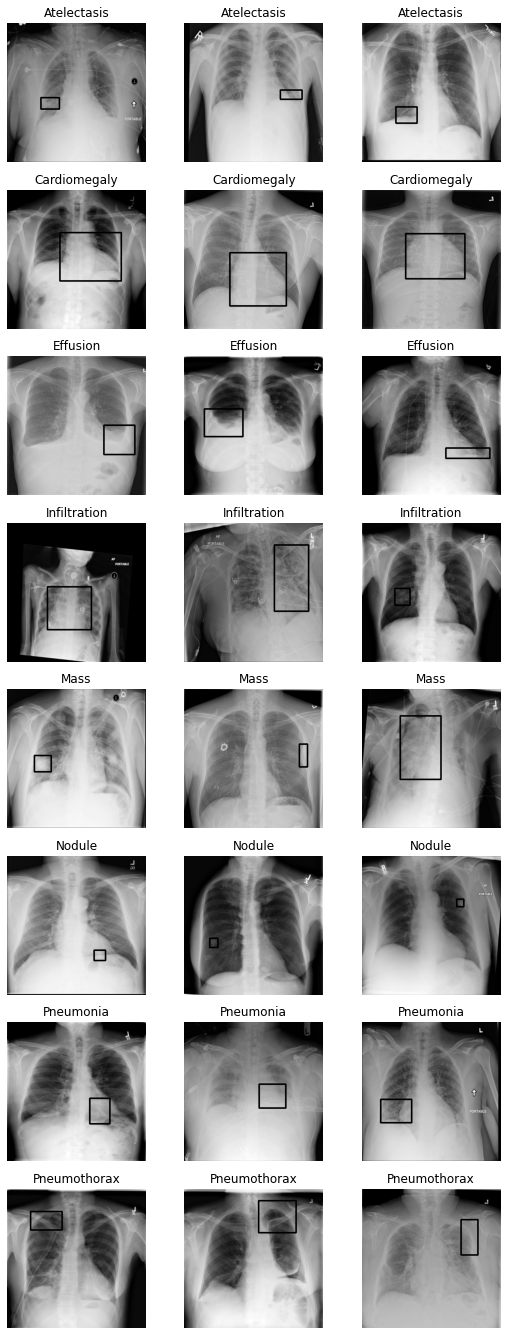

In [ ]:
## Visualize selected samples with bounding boxes
fig = plt.figure(figsize=(no_per_cat*3, no_cat_bb*3))

for i, (index, row) in enumerate(df_bb_grouped.iterrows()):
    ax = fig.add_subplot(no_cat_bb, no_per_cat, i+1)
    img = cv2.imread(row['File Path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    color = (0, 0, 0)
    thick = 2

    ## START
    left = int(row['bb_x'])
    top = int(row['bb_y'])
    right = int(row['bb_x']) + int(row['bb_w'])
    bottom = int(row['bb_y']) + int(row['bb_h'])
    cv2.rectangle(img,(left, top), (right, bottom), color, thick)
    ## END

    plt.imshow(img, cmap="gray")
    plt.title(row['Finding Labels'])
    plt.axis('off')

## Explore characteristics of each category

Tasks:

* Get a mean image of each category
* Visualize difference between selected category (mean) and `No Finding` (mean)
* Get a stdev image of each category

In [ ]:
# Load 25 images from each category into a dictionary
no_per_cat = 25
no_cat = len(df['Finding Labels'].unique()) # includes 'No Finding'
df_grouped = df.groupby(['Finding Labels']).apply(lambda g: g.sample(no_per_cat, random_state=2021))
no_per_cat = 1

loaded_imgs = {}

for index, row in df_grouped.iterrows():
    img = image.load_img(row['File Path'], color_mode = 'grayscale')
    img = image.img_to_array(img)
    try:
        loaded_imgs[row['Finding Labels']].append(img)
    except KeyError:
        loaded_imgs[row['Finding Labels']] = [img]

In [ ]:
## Get a mean image of each category
mean_images = {}
for k, v in loaded_imgs.items():
    ## START
    mean_images[k] = np.mean(v, axis=0)
    ## END

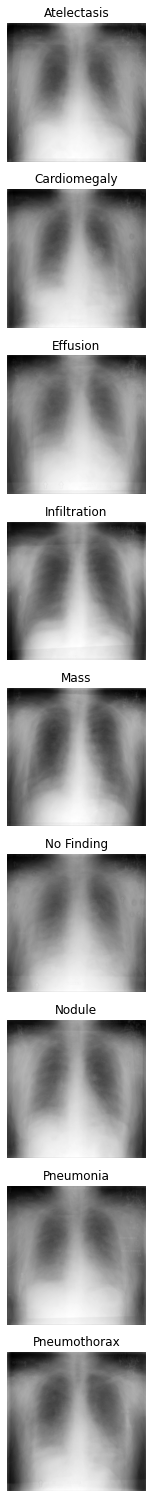

In [ ]:
# Visualize mean image of each category
fig = plt.figure(figsize=(no_per_cat*3, no_cat*3))

for i, (k, v) in enumerate(mean_images.items()):
    ax = fig.add_subplot(no_cat, no_per_cat, i+1)
    plt.imshow(v.squeeze(), cmap='gray')
    plt.title(k)
    plt.axis('off')

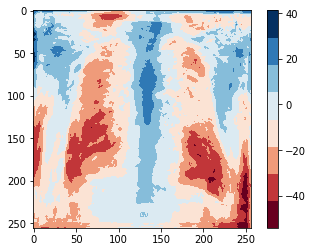

In [ ]:
## Visualize difference between selected category (mean) and `No Finding` (mean)
diff_mean = mean_images['Mass'] - mean_images['No Finding']
cmap = matplotlib.cm.get_cmap('RdBu', 8)
plt.imshow(diff_mean.squeeze(), cmap=cmap)
plt.colorbar() 

Useful resources:

* [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
## Get a stdev image of each category

# which area is most variable in either class by computing variance or standard deviation instead of the mean. Here the lighter area indicates higher variability. Again we can see that in pneumonia X-rays, there is more variability within the lungs.
stddev_images = {}
for k, v in loaded_imgs.items():
    ## START
    stddev_images[k] = np.std(v, axis=0)
    ## END

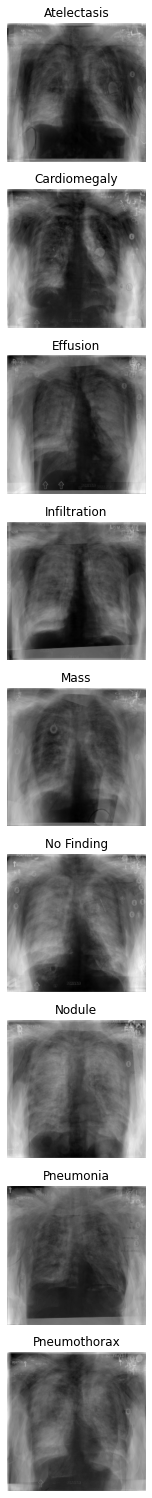

In [ ]:
# Visualize stdev image of each category
fig = plt.figure(figsize=(no_per_cat*3, no_cat*3))

for i, (k, v) in enumerate(stddev_images.items()):
    ax = fig.add_subplot(no_cat, no_per_cat, i+1)
    plt.imshow(v.squeeze(), cmap='gray')
    plt.title(k)
    plt.axis('off')

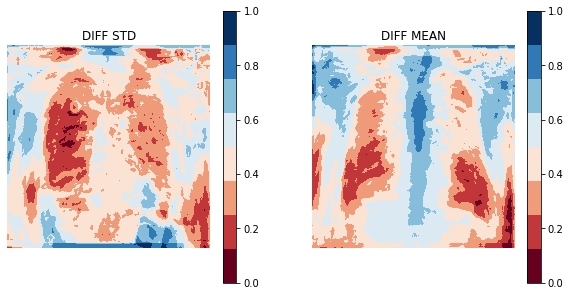

In [ ]:
# Visualize difference between selected category (stdev) and `No Finding` (stdev)

## Motion, displacement, different classes, may not work, only subtle differences

diff_std = stddev_images['Mass'] - stddev_images['No Finding']
cmap = matplotlib.cm.get_cmap('RdBu', 8)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
diff_std_norm = (diff_std-np.min(diff_std))/(np.max(diff_std)-np.min(diff_std))
plt.imshow(diff_std_norm.squeeze(), cmap=cmap)
plt.title('DIFF STD')
plt.axis('off')
plt.colorbar()

ax = fig.add_subplot(1, 2, 2)
diff_mean_norm = (diff_mean-np.min(diff_mean))/(np.max(diff_mean)-np.min(diff_mean))
plt.imshow(diff_mean_norm.squeeze(), cmap=cmap)
plt.title('DIFF MEAN')
plt.axis('off')
plt.colorbar()

Tasks:

* Use PCA to

In [ ]:
## Compute eigenimages using Singular Value Decomposition (SVD)

def eigenimages(full_mat, title, n_comp=0.4):
    ## START
    pca = PCA(n_components=n_comp)
    pca.fit(full_mat)
    ## END
    return pca

In [ ]:
def plot_pca(imgs, cat=''):
    pca = eigenimages(imgs, cat)

    n = pca.n_components_
    r = int(n**.5)
    c = ceil(n/ r)
    fig = plt.figure(figsize=(c*5, r*5))

    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape((256, 256)), cmap=cmap)
    plt.axis('off')
    fig.suptitle(cat, fontsize=14)
    plt.show()

In [ ]:
def convert_imgs(imgs):
    full_mat = []
    for img in imgs:
        img = (img-np.mean(img))/np.std(img)
        full_mat.append(img.ravel())
    return np.asarray(full_mat)

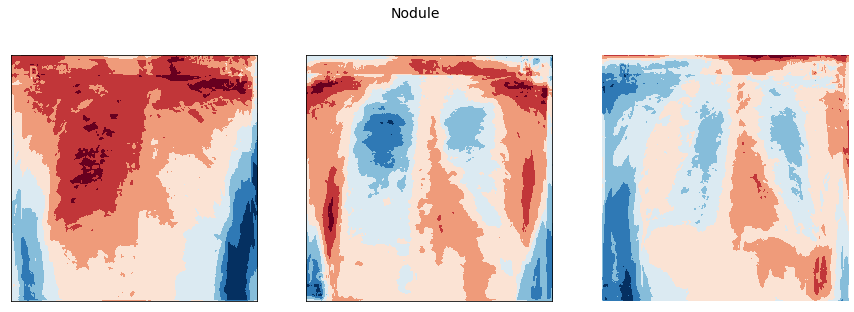

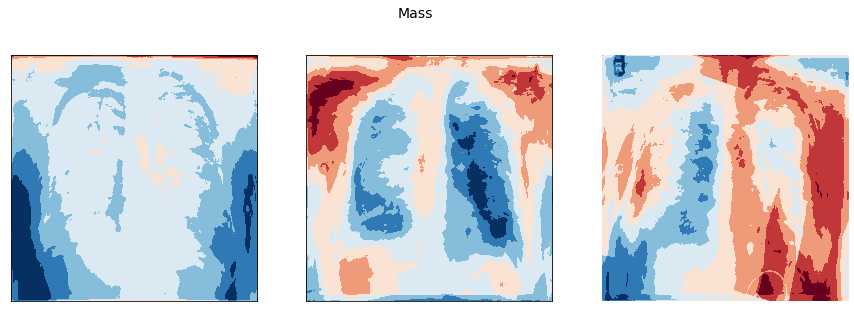

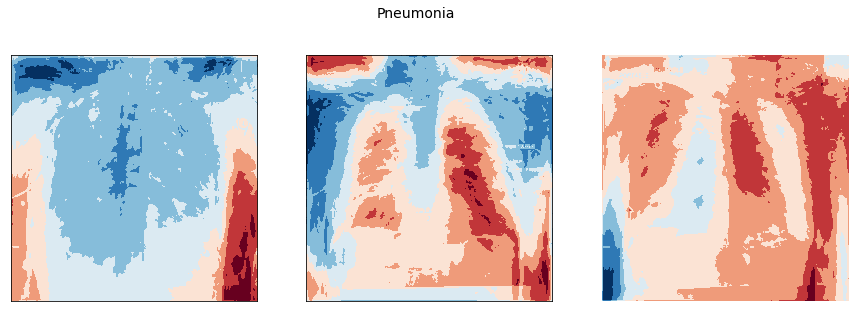

In [ ]:
for cat in ['Nodule', 'Mass', 'Pneumonia']:
    np_imgs = convert_imgs(loaded_imgs[cat])
    plot_pca(np_imgs, cat)

## Relation between various classes and gender

Tasks:

* Create bar plot number of samples in each category w.r.t. gender

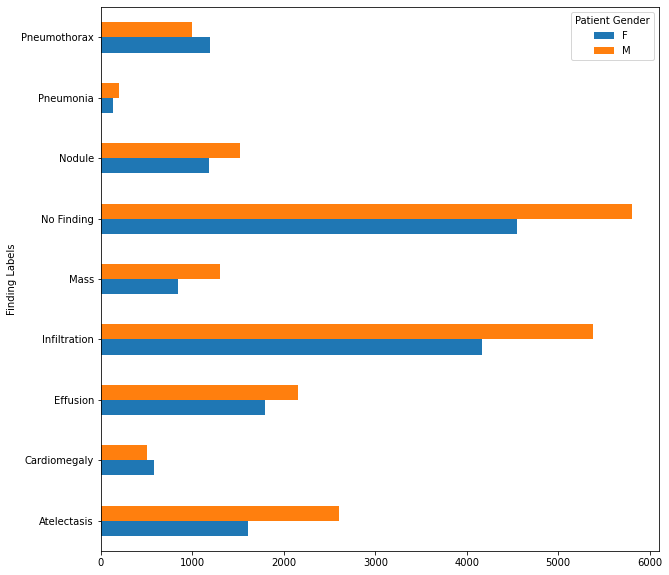

In [ ]:
## Create bar plot number of samples in each category w.r.t. gender

df.groupby('Patient Gender')['Finding Labels'].value_counts().unstack(0).plot.barh(figsize=(10,10))

In [ ]:
## 
df.pivot_table(index='Finding Labels', columns='Patient Gender', aggfunc='size')

Patient Gender,F,M
Finding Labels,,
Atelectasis,1612,2603
Cardiomegaly,585,508
Effusion,1797,2158
Infiltration,4164,5383
Mass,838,1301
No Finding,4550,5811
Nodule,1181,1524
Pneumonia,128,194
Pneumothorax,1193,1001


### AI Fairness

Useful resources:

* [AI Fairness 360](https://aif360.mybluemix.net/)
* [AI Fairness 360 Documentation](https://developer.ibm.com/technologies/artificial-intelligence/projects/ai-fairness-360/)

In [ ]:
!pip install aif360
!pip install fairlearn

In [ ]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics

In [ ]:
cat_1 = 'No Finding'
cat_2 = 'Pneumothorax'

In [ ]:
gender = {'M': 0,'F': 1}
df['Patient_Gender_ID'] = [gender[item] for item in df['Patient Gender']]

In [ ]:
finding_id = {k: i for i, k in enumerate(df.columns[8:-1])}
df['Finding_ID'] = [finding_id[item] for item in df['Finding Labels']]

In [ ]:
df_bin = df[(df['Finding_ID'] == finding_id[cat_1]) | (df['Finding_ID'] == finding_id[cat_2])]
df_bin

,Image Index,Finding Labels,Patient Age,Patient Gender,bb_x,bb_y,bb_w,bb_h,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,No Finding,Nodule,Pneumonia,Pneumothorax,File Path,Patient_Gender_ID,Finding_ID
1,00000005_003.png,No Finding,69,F,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00000005_003.png,1,5
11,00000013_033.png,Pneumothorax,56,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_033.png,0,8
12,00000013_036.png,Pneumothorax,56,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_036.png,0,8
13,00000013_039.png,Pneumothorax,56,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_039.png,0,8
17,00000013_011.png,Pneumothorax,60,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_011.png,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36525,00030787_000.png,No Finding,33,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030787_000.png,0,5
36527,00030798_000.png,No Finding,29,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030798_000.png,0,5
36528,00030799_000.png,No Finding,32,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030799_000.png,0,5
36529,00030800_000.png,No Finding,33,F,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030800_000.png,1,5


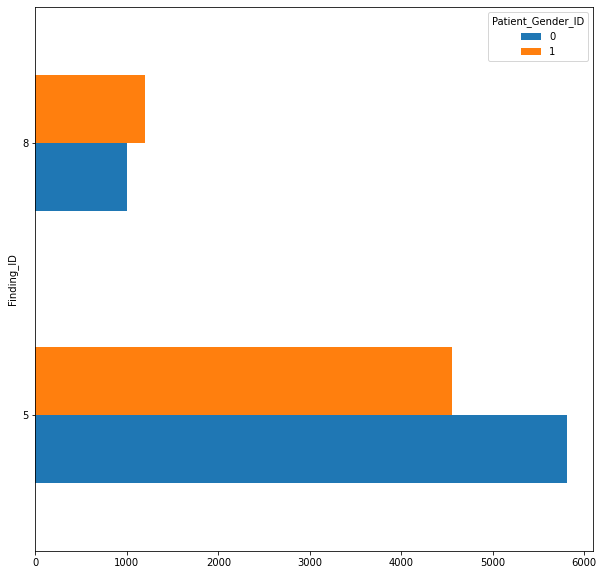

In [ ]:
df_bin.groupby('Patient_Gender_ID')['Finding_ID'].value_counts().unstack(0).plot.barh(figsize=(10,10))

In [ ]:
df_bin.query('Patient_Gender_ID == 0')

,Image Index,Finding Labels,Patient Age,Patient Gender,bb_x,bb_y,bb_w,bb_h,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,No Finding,Nodule,Pneumonia,Pneumothorax,File Path,Patient_Gender_ID,Finding_ID
11,00000013_033.png,Pneumothorax,56,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_033.png,0,8
12,00000013_036.png,Pneumothorax,56,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_036.png,0,8
13,00000013_039.png,Pneumothorax,56,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_039.png,0,8
17,00000013_011.png,Pneumothorax,60,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_011.png,0,8
18,00000013_012.png,Pneumothorax,60,M,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,data/images/00000013_012.png,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36521,00030773_000.png,No Finding,9,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030773_000.png,0,5
36525,00030787_000.png,No Finding,33,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030787_000.png,0,5
36527,00030798_000.png,No Finding,29,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030798_000.png,0,5
36528,00030799_000.png,No Finding,32,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030799_000.png,0,5


In [ ]:
query = 'Patient_Gender_ID == 1 & Finding ID == {}'.format(finding_id[cat_1])
df_bias = df_bin.drop(df_bin.query('Patient_Gender_ID == 1 & Finding_ID == {}'.format(finding_id[cat_1])).sample(frac=.99).index)
df_bias = df_bias.drop(df_bias.query('Patient_Gender_ID == 0 & Finding_ID == {}'.format(finding_id[cat_2])).sample(frac=.9).index)
df_bias = df_bias.drop(df_bias.query('Patient_Gender_ID == 0 & Finding_ID == {}'.format(finding_id[cat_1])).sample(frac=.9).index)
df_bias = df_bias.drop(df_bias.query('Patient_Gender_ID == 1 & Finding_ID == {}'.format(finding_id[cat_2])).sample(frac=.9).index)

Patient_Gender_ID  Finding_ID
0                  5             581
                   8             100
1                  8             119
                   5              46
Name: Finding_ID, dtype: int64

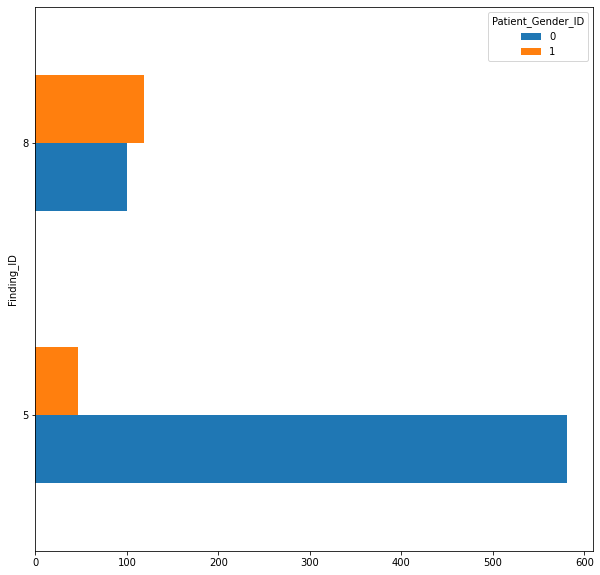

In [ ]:
df_bias.groupby('Patient_Gender_ID')['Finding_ID'].value_counts().unstack(0).plot.barh(figsize=(10,10))
df_bias.groupby('Patient_Gender_ID')['Finding_ID'].value_counts()

In [ ]:
df_bias_copy = df_bias.copy()
df_bias = df_bias[['Patient_Gender_ID', 'Finding_ID']]
df_bias

,Patient_Gender_ID,Finding_ID
176,0,8
207,0,5
350,0,5
381,0,8
410,0,5
...,...,...
36348,0,5
36402,0,8
36403,0,8
36410,0,5


In [ ]:
train_bld = BinaryLabelDataset(
    df=df_bias,
    label_names=['Finding_ID'],
    protected_attribute_names=['Patient_Gender_ID'],  # Protected attributes are those qualities, traits or characteristics that, by law, cannot be discriminated against.
    favorable_label=finding_id[cat_1],
    unfavorable_label=finding_id[cat_2],
)
train_bld

               instance weights            features labels
                                protected attribute       
                                  Patient_Gender_ID       
instance names                                            
176                         1.0                 0.0    8.0
207                         1.0                 0.0    5.0
350                         1.0                 0.0    5.0
381                         1.0                 0.0    8.0
410                         1.0                 0.0    5.0
...                         ...                 ...    ...
36348                       1.0                 0.0    5.0
36402                       1.0                 0.0    8.0
36403                       1.0                 0.0    8.0
36410                       1.0                 0.0    5.0
36448                       1.0                 0.0    5.0

[846 rows x 3 columns]

In [ ]:
privileged_groups = [{'Patient_Gender_ID': 0}]
unprivileged_groups = [{'Patient_Gender_ID': 1}]

In [ ]:
metric_train_bld = BinaryLabelDatasetMetric(
    train_bld,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

In [ ]:
explainer = MetricTextExplainer(metric_train_bld)

print(dir(MetricTextExplainer))

print(explainer.statistical_parity_difference())
print(explainer.disparate_impact())

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'accuracy', 'average_abs_odds_difference', 'average_odds_difference', 'between_all_groups_coefficient_of_variation', 'between_all_groups_generalized_entropy_index', 'between_all_groups_theil_index', 'between_group_coefficient_of_variation', 'between_group_generalized_entropy_index', 'between_group_theil_index', 'coefficient_of_variation', 'consistency', 'disparate_impact', 'equal_opportunity_difference', 'error_rate', 'error_rate_difference', 'error_rate_ratio', 'false_discovery_rate', 'false_discovery_rate_difference', 'false_discovery_rate_ratio', 'false_negative_rate', 'false_negative_rate_differ

In [ ]:
rw = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

# https://github.com/Trusted-AI/AIF360/blob/master/aif360/sklearn/preprocessing/reweighing.py#L91

train_bld_f = rw.fit_transform(train_bld)

train_bld_f

df_bias['sample weight'] = train_bld_f.instance_weights
df_bias_copy['sample weight'] = train_bld_f.instance_weights
df_bias.drop_duplicates()

,Patient_Gender_ID,Finding_ID,sample weight
176,0,8,1.762872
207,0,5,0.868697
479,1,5,2.658418
505,1,8,0.358931


In [ ]:
DATA_DIR = 'data/'
df_bias_copy.reindex()
df_bias_copy.to_csv(os.path.join(DATA_DIR, 'data_sample_weights.csv'))

## Relation between various classes and age

Finding Labels
Atelectasis     AxesSubplot(0.125,0.125;0.775x0.755)
Cardiomegaly    AxesSubplot(0.125,0.125;0.775x0.755)
Effusion        AxesSubplot(0.125,0.125;0.775x0.755)
Infiltration    AxesSubplot(0.125,0.125;0.775x0.755)
Mass            AxesSubplot(0.125,0.125;0.775x0.755)
No Finding      AxesSubplot(0.125,0.125;0.775x0.755)
Nodule          AxesSubplot(0.125,0.125;0.775x0.755)
Pneumonia       AxesSubplot(0.125,0.125;0.775x0.755)
Pneumothorax    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Patient Age, dtype: object

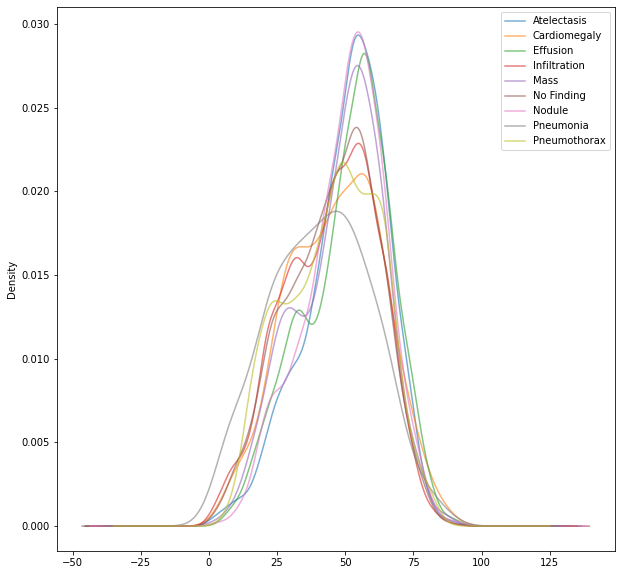

In [ ]:
df.groupby('Finding Labels')['Patient Age'].plot(kind='kde', alpha=0.6, legend=True, figsize=(10,10))

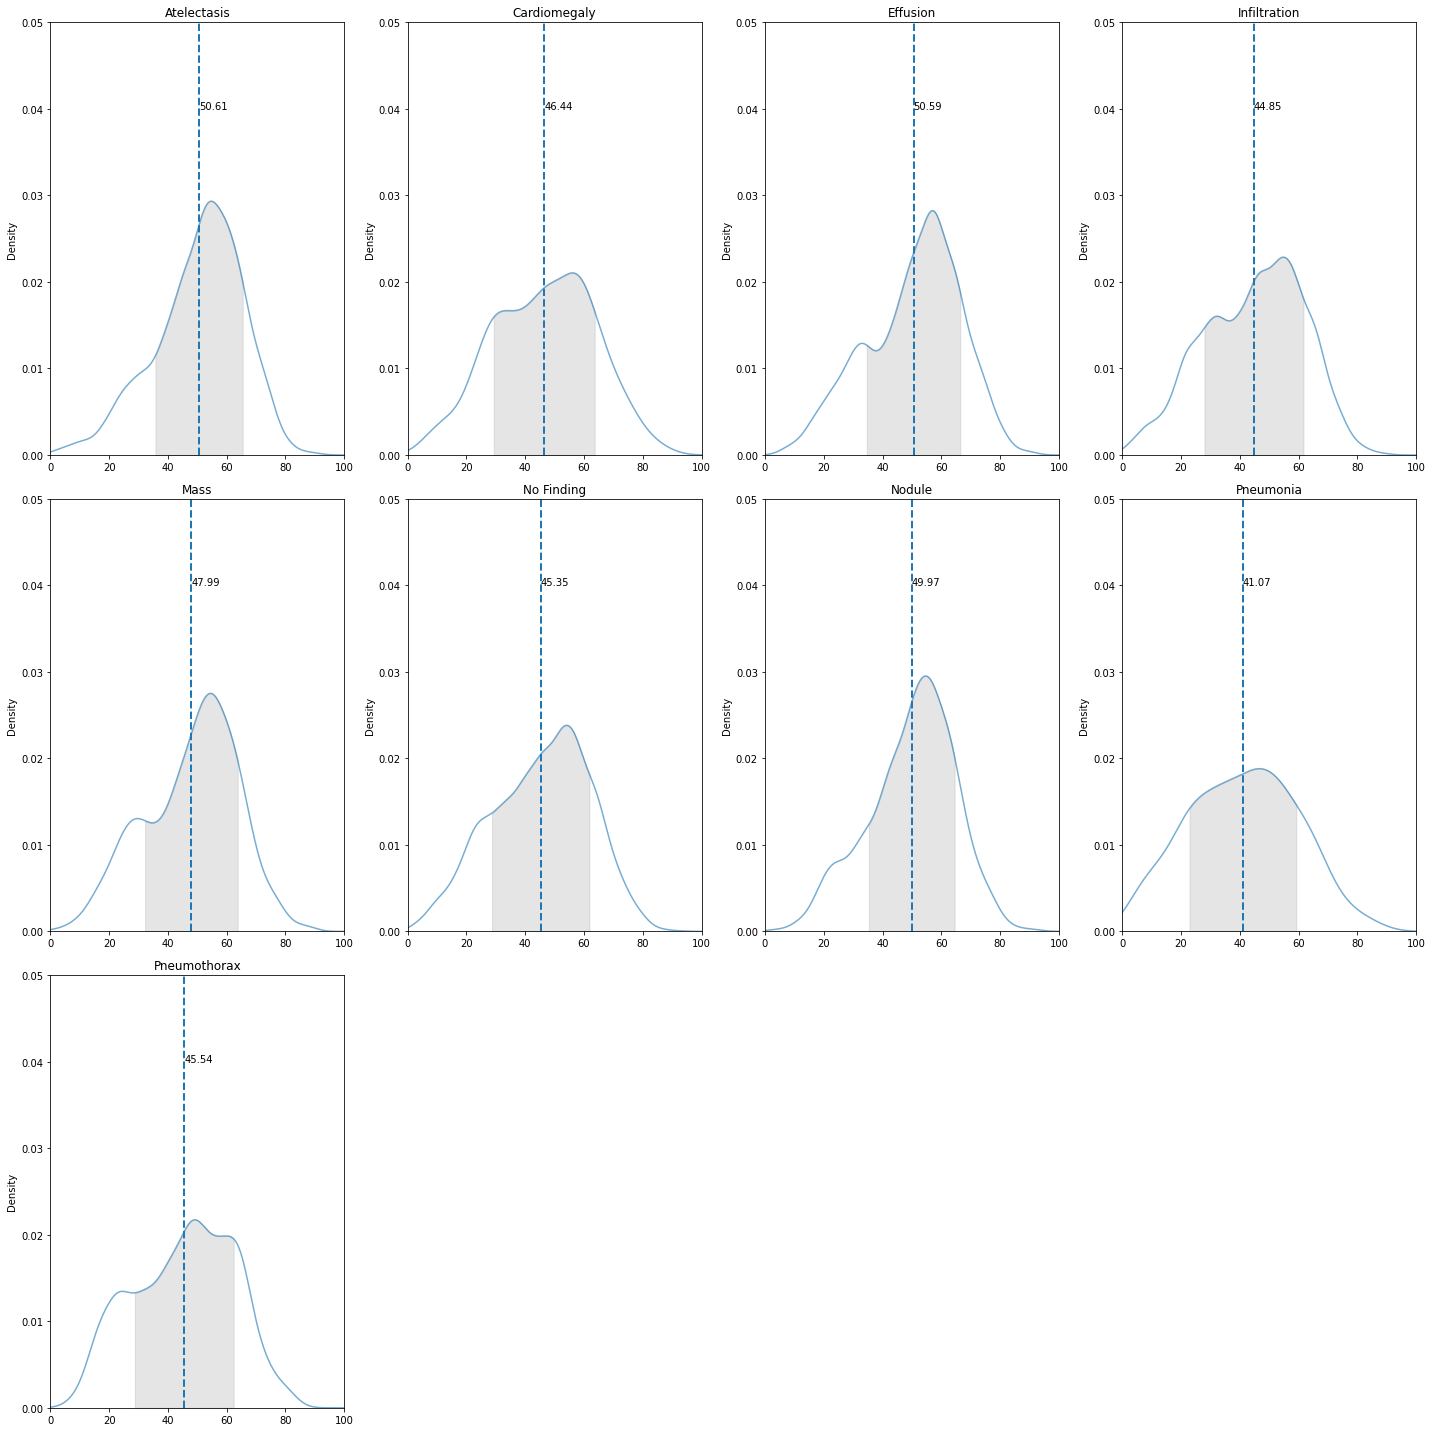

In [ ]:
no_cat = len(df['Finding Labels'].unique())

fig = plt.figure(figsize=(4*15, int(np.ceil(no_cat/4))*15))

for i, (name, group) in enumerate(df.groupby('Finding Labels')['Patient Age']):
    ax = fig.add_subplot(int(np.ceil(no_cat/4)), 4, i+1)
    mean = np.mean(group)
    stddev = np.std(group)
    group.plot(kind='kde', alpha=0.6, figsize=(20,20))
    ax.fill_between(ax.lines[0].get_xdata(), 0, ax.lines[0].get_ydata(),
                   where=((mean-stddev) <= ax.lines[0].get_xdata()) & (ax.lines[0].get_xdata() <= (mean+stddev)),
                   color='gray', alpha=0.2)
    ax.axvline(mean, linestyle='dashed', linewidth=2)
    ax.annotate('{:.2f}'.format(mean), [mean, 0.04])
    ax.set_title(name)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 0.05])

plt.tight_layout()